In [35]:
import sys
sys.path.append('..')

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from typing import List
import numpy as np
from tqdm.notebook import trange as trange
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from utils.data_utils import *
from test_framework.model_interface import ModelInterface
from test_framework.tester import Tester
from test_framework.metrics import *
from active_learning.categorical_query_functions import *
from active_learning.gradient_embedding import compute_gradient_embeddings
from active_learning.cluster_margin import *

## Dataset and Model Constants

In [38]:
# Data Constants
DATA_DIR = "../data/kaggle_satellite_image_classification"
NUM_CLASSES = 4
MAIN_IMG_DIMS = (64, 64)
SECONDARY_IMG_DIMS = (32, 32)
MAX_SECONDARY_IMAGES = 5

# Model Constants
FINAL_LAYER_LEN = 64

# Training Constants
TEST_DATA_FRACTION = 0.05

## Load Dataset, creating secondary modality

0.5139103
Label = [0. 1. 0. 0.]


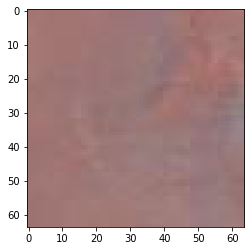

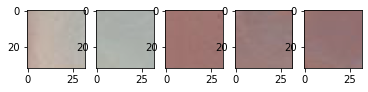

Label = [0. 1. 0. 0.]


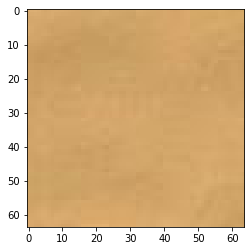

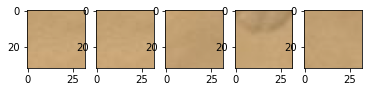

Label = [0. 0. 1. 0.]


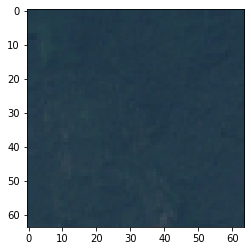

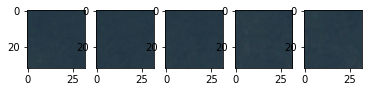

Label = [0. 0. 1. 0.]


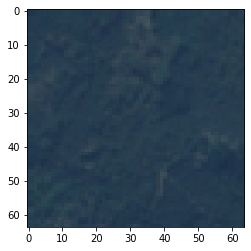

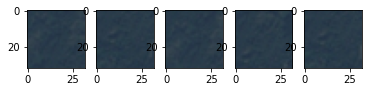

In [39]:
def load_dataset_as_numpy(max_samples: int = None):
    def transform_to_multimodal(image):
        main_image = transforms.Compose([
            transforms.CenterCrop(MAIN_IMG_DIMS),
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(image.copy())

        secondary_images = [
            transforms.Compose([
                transforms.RandomCrop(SECONDARY_IMG_DIMS),
                transforms.ToTensor(),
                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                transforms.Lambda(lambda img: transforms.functional.adjust_contrast(img, contrast_factor=0.8))
            ])(image.copy()) for i in range(MAX_SECONDARY_IMAGES)
        ]
        secondary_images = torch.stack(secondary_images)
        
        return main_image, secondary_images

    dataset = datasets.ImageFolder(DATA_DIR, transform=transform_to_multimodal)
    output_sample_count = len(dataset) if max_samples is None or max_samples >= len(dataset) else max_samples
    all_data_dataloader = torch.utils.data.DataLoader(dataset, batch_size=output_sample_count, num_workers=0, shuffle=True)
    (main_image_all, secondary_images_all), y_all = next(iter(all_data_dataloader))

    # Convert y to one-hot array
    y_all = torch.eye(NUM_CLASSES)[y_all]

    return main_image_all.numpy(), secondary_images_all.numpy(), y_all.numpy()

x_main, x_secondary, y = load_dataset_as_numpy()


# Display some examples
print(np.mean(x_main[0]))
for i in range(4):
    print(f"Label = {y[i]}")
    plt.imshow(x_main[i].transpose(1, 2, 0))
    plt.show()
    fig, axarr = plt.subplots(1, MAX_SECONDARY_IMAGES)
    for j in range(MAX_SECONDARY_IMAGES):
        axarr[j].imshow(x_secondary[i][j].transpose(1, 2, 0))
    plt.show()
plt.close('all')

## Create Simple Late Fusion Model

In [40]:
class MultiModalLateFusionModel(nn.Module):
    def __init__(self):
        super(MultiModalLateFusionModel, self).__init__()

        # Simple convolutional network operates on original full images,
        # and outputs a set of features useful for a final classification layer
        self.main_branch = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 16, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(16 * (MAIN_IMG_DIMS[0] // 2**3) * (MAIN_IMG_DIMS[1] // 2**3), FINAL_LAYER_LEN // 2),
            nn.Tanh()
        )

        # This secondary branch operates on cropped parts of the image with
        # increased contrast. If there are multiple secondary images, we use
        # the average of the features output by this branch
        self.secondary_branch = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 16, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(16 * (SECONDARY_IMG_DIMS[0] // 2**3) * (SECONDARY_IMG_DIMS[1] // 2**3), FINAL_LAYER_LEN // 2),
            nn.Tanh()
        )

        # Single dense layer which combines information directly after fusing both model modes
        self.post_fusion_layer = nn.Linear(FINAL_LAYER_LEN, NUM_CLASSES)


    '''
    Args:
        main_image (torch.Tensor):          Shape = (batch_size, 3, *(MAIN_IMG_DIMS))
        secondary_images (torch.Tensor):    Variable size list of cropped high-contrast parts
                                            of the main image. The list is padded to the max
                                            length with images of all zeros.
                                            Shape = (batch_size, MAX_SECONDARY_IMAGES, 3, *(SECONDARY_IMG_DIMS))  
    '''
    def forward(self, main_image: torch.Tensor, secondary_images: torch.Tensor) -> torch.Tensor:
        batch_size = main_image.shape[0]
        
        # Compute main branch
        main_features = self.main_branch(main_image)

        # Count the number of secondary images
        slot_has_image = (secondary_images != torch.zeros(3, *SECONDARY_IMG_DIMS).to(DEVICE)).reshape(batch_size, MAX_SECONDARY_IMAGES, -1).prod(dim=-1, keepdim=True) # shape = (batch_size, MAX_SECONDARY_IMAGES, 1)
        image_count_per_sample = slot_has_image.sum(dim=1) # shape = (batch_size, 1)

        # Compute features for every possible secondary image
        all_secondary_images = secondary_images.reshape(batch_size * MAX_SECONDARY_IMAGES, 3, *SECONDARY_IMG_DIMS)
        all_secondary_features = self.secondary_branch(all_secondary_images).reshape(batch_size, MAX_SECONDARY_IMAGES, -1)

        # Mask out features for secondary image slots that didn't contain an actual image (i.e. were all zeros)
        masked_secondary_image_features = all_secondary_features * slot_has_image

        # Average the secondary branch features of all included secondary branches
        averaged_secondary_image_features = masked_secondary_image_features.sum(dim=1) / image_count_per_sample

        # Concatenate both feature modes
        fused_features = torch.cat([main_features, averaged_secondary_image_features], dim=1)

        # Pass through final layer
        output_logits = self.post_fusion_layer(fused_features)

        output_probabilities = torch.softmax(output_logits, dim=1)
        return output_probabilities

## Create Model Interface to plug model into active learning test framework

In [55]:
# This interface uses the multimodal model above with a specified query function
class MultiModalLateFusionModelInterface(ModelInterface):
    def __init__(self, query_function_name: str, active_learning_batch_size: int = 32):
        self.query_function_name = query_function_name
        self.active_learning_batch_size = active_learning_batch_size

        # Model Training Constants
        self.TRAINING_MINIBATCH_SIZE = 128

        self.reset()
        

    def name(self):
        return self.query_function_name

    def reset(self):
        self.model = MultiModalLateFusionModel().to(DEVICE)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        # For cluster-margin active learning algorithm, clusters must be
        # saved between queries
        if self.query_function_name == "CLUSTER_MARGIN":
            self.cluster_margin = ClusterMarginQueryFunction(
                self.model, [self.model.post_fusion_layer.weight],
                margin_batch_size = 2 * self.active_learning_batch_size,
                target_batch_size = self.active_learning_batch_size
            )
        else:
            self.cluster_margin = None

    def train(self, train_x: List[np.ndarray], train_y: np.ndarray) -> None:
        data_len = train_y.shape[0]

        # Extract specific data modes
        x_main, x_secondary = train_x
        
        # Pass through all minibatches in training set, but skip any partial minibatch at the end
        batch_start = 0
        while batch_start + self.TRAINING_MINIBATCH_SIZE < data_len:
            x_main_minibatch = torch.from_numpy(x_main[batch_start : batch_start + self.TRAINING_MINIBATCH_SIZE]).to(DEVICE)
            x_secondary_minibatch = torch.from_numpy(x_secondary[batch_start : batch_start + self.TRAINING_MINIBATCH_SIZE]).to(DEVICE)
            y_minibatch = torch.from_numpy(train_y[batch_start : batch_start + self.TRAINING_MINIBATCH_SIZE]).to(DEVICE)

            # Train on minibatch
            self.opt.zero_grad()

            model_output = self.model(
                x_main_minibatch,
                x_secondary_minibatch
            )

            # Compute cross-entropy loss
            loss = -torch.mean(torch.sum(y_minibatch * torch.log(model_output + 1e-9), dim=1))
            loss.backward()
            self.opt.step()

            # Iterate minibatch
            batch_start += self.TRAINING_MINIBATCH_SIZE

    def predict(self, test_x: List[np.ndarray]) -> np.ndarray:
        data_len = test_x[0].shape[0]
        output = np.zeros((data_len, NUM_CLASSES))

        with torch.no_grad():
            # Extract specific data modes
            x_main, x_secondary = test_x

            # Iterate through minibatches without skipping partial ending
            batch_start = 0
            while batch_start < data_len:
                current_minibatch_size = min(self.TRAINING_MINIBATCH_SIZE, data_len - batch_start)

                # Convert to tensors
                x_main_minibatch = torch.from_numpy(x_main[batch_start : batch_start + current_minibatch_size]).to(DEVICE)
                x_secondary_minibatch = torch.from_numpy(x_secondary[batch_start : batch_start + current_minibatch_size]).to(DEVICE)
                
                predictions = self.model(
                    x_main_minibatch,
                    x_secondary_minibatch
                )
                output[batch_start : batch_start + current_minibatch_size] = predictions.cpu().numpy()

                # Iterate minibatch
                batch_start += current_minibatch_size

        return output

    def query(self, unlabeled_data: List[np.ndarray], labeling_batch_size: int) -> np.ndarray:
        if self.query_function_name == "RANDOM":
            data_size = unlabeled_data[0].shape[0]
            return np.random.choice(np.arange(data_size), size=labeling_batch_size, replace=False)
        
        if self.query_function_name == "MIN_MAX":
            return MIN_MAX(self.predict(unlabeled_data), labeling_batch_size)

        if self.query_function_name == "MIN_MARGIN":
            return MIN_MARGIN(self.predict(unlabeled_data), labeling_batch_size)

        if self.query_function_name == "MAX_ENTROPY":
            return MAX_ENTROPY(self.predict(unlabeled_data), labeling_batch_size)

        if self.query_function_name == "CLUSTER_MARGIN":
            return self.cluster_margin.query(unlabeled_data)

        raise ValueError(f"Unrecognized query function name: {self.query_function_name}")

## Test Basic Active Learning on this model

In [60]:
tester = Tester([x_main, x_secondary], y)
tester.INITIAL_TRAIN_DATA_FRACTION = 0.05
tester.ACTIVE_LEARNING_BATCH_SIZE = 256
tester.TRAINING_EPOCHS = 4
tester.TEST_REPEAT_COUNT = 2

Test 1: Data size 2512: : 100%|██████████| 10/10 [01:42<00:00, 10.20s/it, data_size=2512, test_acc=0.868, train_acc=0.811]


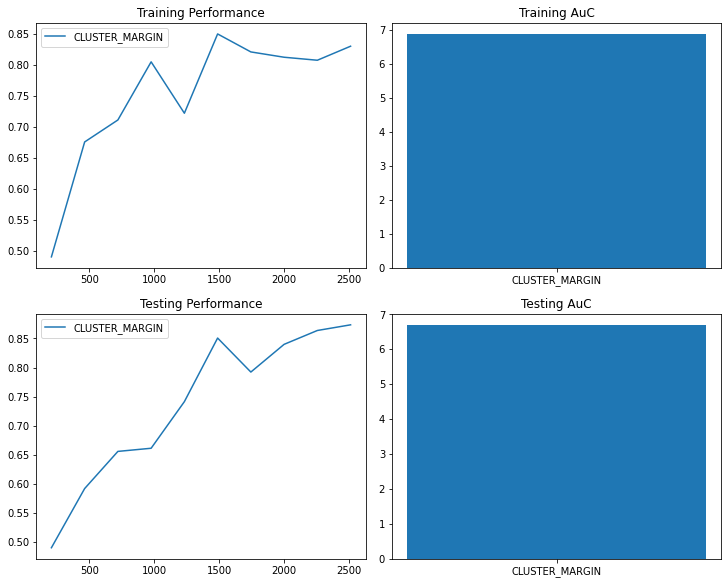

Test 1: Data size 2512: : 100%|██████████| 10/10 [00:55<00:00,  5.60s/it, data_size=2512, test_acc=0.89, train_acc=0.883]


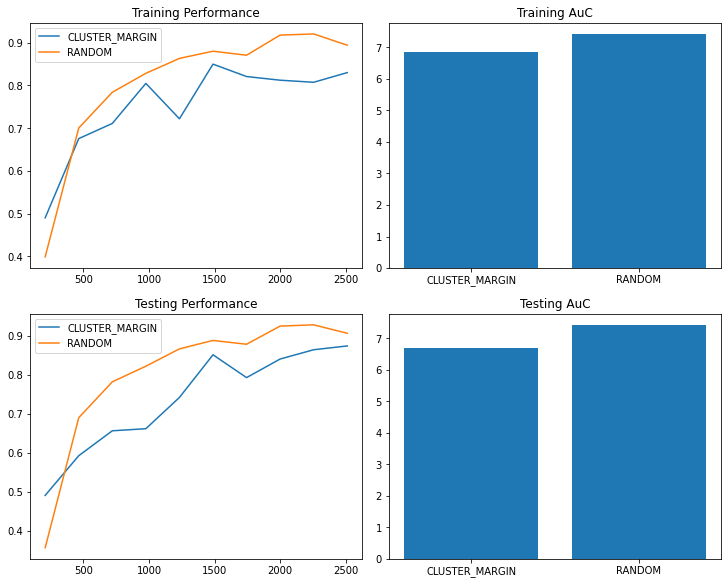

Test 1: Data size 2512: : 100%|██████████| 10/10 [01:04<00:00,  6.47s/it, data_size=2512, test_acc=0.411, train_acc=0.529]


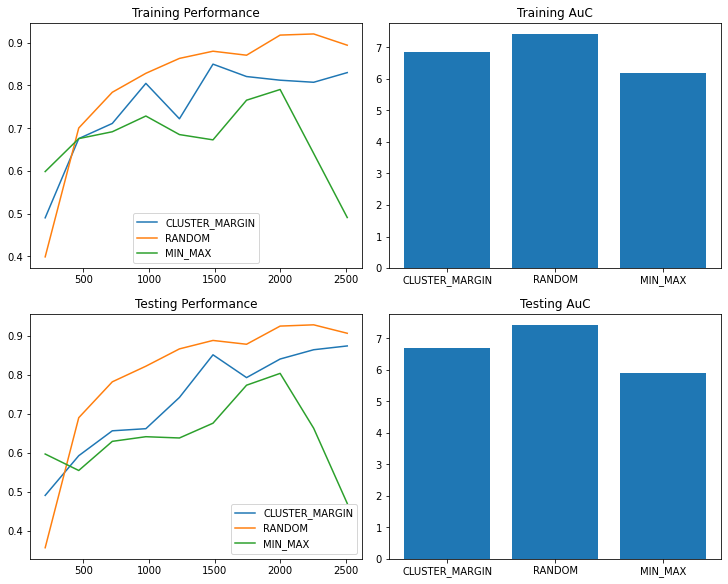

Test 1: Data size 2512: : 100%|██████████| 10/10 [01:05<00:00,  6.53s/it, data_size=2512, test_acc=0.721, train_acc=0.728]


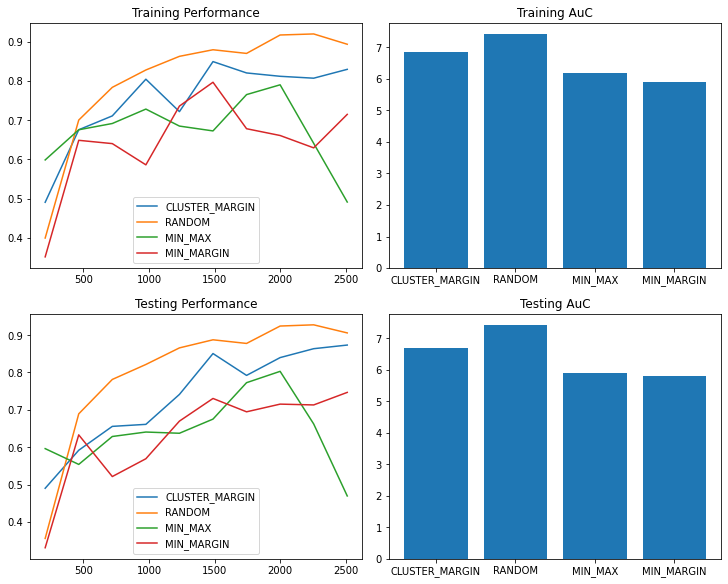

Test 1: Data size 2512: : 100%|██████████| 10/10 [01:05<00:00,  6.54s/it, data_size=2512, test_acc=0.623, train_acc=0.763]


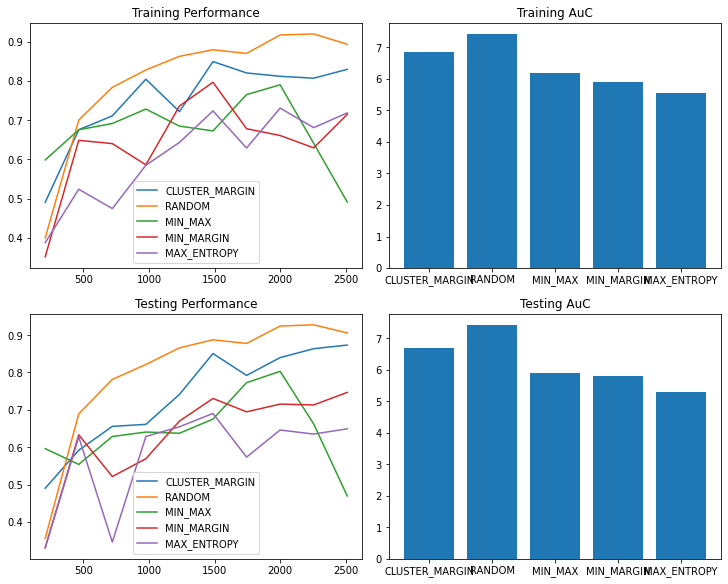

In [61]:
tester.test_model(MultiModalLateFusionModelInterface("CLUSTER_MARGIN", tester.ACTIVE_LEARNING_BATCH_SIZE))
tester.plot_results(plot_savename="test_2_results.png")
tester.test_model(MultiModalLateFusionModelInterface("RANDOM"))
tester.plot_results()
tester.test_model(MultiModalLateFusionModelInterface("MIN_MAX"))
tester.plot_results()
tester.test_model(MultiModalLateFusionModelInterface("MIN_MARGIN"))
tester.plot_results()
tester.test_model(MultiModalLateFusionModelInterface("MAX_ENTROPY"))
tester.plot_results()

## Investigating Gradient Embeddings

  0%|          | 0/1 [00:00<?, ?it/s]

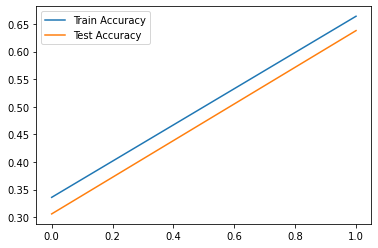

In [ ]:
model_interface = MultiModalLateFusionModelInterface("CLUSTER_MARGIN")

# Train on some part of the data
labeled_size = round(0.9 * len(x_main))
x_main_labeled = x_main[:labeled_size]
x_secondary_labeled = x_secondary[:labeled_size]
y_labeled = y[:labeled_size]
x_main_unlabeled = x_main[labeled_size:]
x_secondary_unlabeled = x_secondary[labeled_size:]
y_unlabeled = y[labeled_size:]

# Log training as sanity check
train_accuracy_curve = []
test_accuracy_curve = []
train_acc = ACCURACY(y_labeled, model_interface.predict([x_main_labeled, x_secondary_labeled]))
test_acc = ACCURACY(y_unlabeled, model_interface.predict([x_main_unlabeled, x_secondary_unlabeled]))
train_accuracy_curve.append(train_acc)
test_accuracy_curve.append(test_acc)

epoch_count = 10
epoch_range = trange(epoch_count)
epoch_range.set_postfix(train_acc=train_acc, test_acc=test_acc)
for epoch in epoch_range:
    model_interface.train([x_main_labeled, x_secondary_labeled], y_labeled)

    train_acc = ACCURACY(y_labeled, model_interface.predict([x_main_labeled, x_secondary_labeled]))
    test_acc = ACCURACY(y_unlabeled, model_interface.predict([x_main_unlabeled, x_secondary_unlabeled]))
    train_accuracy_curve.append(train_acc)
    test_accuracy_curve.append(test_acc)

    epoch_range.set_postfix(train_acc=train_acc, test_acc=test_acc)

plt.plot(train_accuracy_curve, label="Train Accuracy")
plt.plot(test_accuracy_curve, label="Test Accuracy")
plt.legend()
plt.show()


In [ ]:
embeddings_labeled, embedding_ind_to_param_ind = compute_gradient_embeddings(model_interface.model, [model_interface.model.post_fusion_layer.weight], [x_main_labeled, x_secondary_labeled])